In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error,r2_score
import tensorflow as tf
import talib
from tensorflow import keras
from sklearn.pipeline import make_pipeline
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping
from yahoofinancials import YahooFinancials

In [2]:
data=yf.download('^HSI','2019-01-01','2022-01-01')
data=data.drop('Volume',1)
data['Prediction']=data['Close'].shift(-1)
data.dropna(inplace=True)
data

[*********************100%***********************]  1 of 1 completed


/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_94886/271620078.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data=data.drop('Volume',1)


,Open,High,Low,Close,Adj Close,Prediction
Date,,,,,,
2019-01-02,25824.439453,25824.439453,25055.269531,25130.349609,25130.349609,25064.359375
2019-01-03,25077.679688,25262.210938,24896.869141,25064.359375,25064.359375,25626.029297
2019-01-04,24946.119141,25626.029297,24924.730469,25626.029297,25626.029297,25835.699219
2019-01-07,26015.839844,26043.640625,25753.460938,25835.699219,25835.699219,25875.449219
2019-01-08,25852.500000,25960.890625,25688.500000,25875.449219,25875.449219,26462.320312
...,...,...,...,...,...,...
2021-12-23,23141.789062,23264.750000,23027.150391,23193.640625,23193.640625,23223.759766
2021-12-24,23375.990234,23383.189453,23186.570312,23223.759766,23223.759766,23280.560547
2021-12-28,23282.349609,23319.439453,23099.480469,23280.560547,23280.560547,23086.539062


In [3]:
# data['6day MA'] = data['Close'].rolling(window = 6).mean()
# data['12day MA'] = data['Close'].rolling(window = 12).mean()
# data['RSI'] = talib.RSI(data['Close'].values, timeperiod = 7)
# data['%R5'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 5)
# data['%R10'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 10)
# data['MI6']=talib.MOM(data['Close'],timeperiod=6)
# data['MI12']=talib.MOM(data['Close'],timeperiod=12)
# macd, macdsignal, macdhist = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
# data['EMA12']=talib.EMA(data['Close'], timeperiod=12)
# data['EMA26']=talib.EMA(data['Close'],timeperiod=26)
# data['MACD']=macd
# data['TR']=talib.TRANGE(data['High'],data['Low'],data['Close'])
# data['OSC6']=talib.CMO(data['Close'], timeperiod=6)
# data['OSC12']=talib.CMO(data['Close'], timeperiod=12)
data['Prediction']=data['Close'].shift(-1)
data.dropna(inplace=True)

In [4]:
data_val=data[-100:]
data=data[:-100]

In [5]:
sc = MinMaxScaler(feature_range = (-1, 1))

In [6]:
X=sc.fit_transform(data.drop('Prediction',1))
# X=data.drop('Prediction',1).values
# Y = data["Prediction"].values.reshape(-1,1)
# Y = sc_y.fit_transform(data["Prediction"].values.reshape(-1,1))
Y=np.array(data["Prediction"])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,shuffle=False)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(511, 1, 5) (511,) (128, 1, 5) (128,)


/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_94886/1866109569.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=sc.fit_transform(data.drop('Prediction',1))


In [7]:
model_tech = keras.Sequential()
model_tech.add(keras.layers.LSTM(
  units=128,
  input_shape=(X_train.shape[1], X_train.shape[2]),
    return_sequences=True
   
))
model_tech.add(keras.layers.LSTM(units=64))
model_tech.add(keras.layers.Dense(units=64))
model_tech.add(keras.layers.Dense(units=1))
model_tech.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001)
)

Metal device set to: Apple M1 Pro


2022-04-12 23:08:10.341482: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-12 23:08:10.341605: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=40, min_delta=0.001)
history_tech=model_tech.fit(
    X_train, y_train,
    epochs=500,
    batch_size=8,
    validation_split=0.1,
    verbose=1,
    shuffle=False,
)
y_pred = model_tech.predict(X_test)

Epoch 1/500


2022-04-12 23:08:10.755876: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-12 23:08:11.963104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 23:08:12.169212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 23:08:12.380305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 6/58 [==>...........................] - ETA: 0s - loss: 772332992.0000  

2022-04-12 23:08:12.726905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 23:08:12.813290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - 4s 29ms/step - loss: 701998080.0000 - val_loss: 744859840.0000
Epoch 2/500
 1/58 [..............................] - ETA: 0s - loss: 678374528.0000

2022-04-12 23:08:14.329757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 23:08:14.401785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 23:08:14.424423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - 1s 13ms/step - loss: 700995520.0000 - val_loss: 740379456.0000
Epoch 3/500
58/58 [==============================] - 1s 10ms/step - loss: 692355264.0000 - val_loss: 726127616.0000
Epoch 4/500
58/58 [==============================] - 1s 10ms/step - loss: 676560512.0000 - val_loss: 709819968.0000
Epoch 5/500
58/58 [==============================] - 1s 9ms/step - loss: 659831616.0000 - val_loss: 691944960.0000
Epoch 6/500
58/58 [==============================] - 1s 11ms/step - loss: 641689664.0000 - val_loss: 672314496.0000
Epoch 7/500
58/58 [==============================] - 1s 9ms/step - loss: 621861120.0000 - val_loss: 650908416.0000
Epoch 8/500
58/58 [==============================] - 1s 9ms/step - loss: 600372480.0000 - val_loss: 627823296.0000
Epoch 9/500
58/58 [==============================] - 1s 12ms/step - loss: 577346816.0000 - val_loss: 603214336.0000
Epoch 10/500
58/58 [==============================] - 1s 10ms/step - loss: 552952384.00

58/58 [==============================] - 1s 10ms/step - loss: 2166652.5000 - val_loss: 1739874.5000
Epoch 74/500
58/58 [==============================] - 1s 9ms/step - loss: 1827440.7500 - val_loss: 1661589.8750
Epoch 75/500
58/58 [==============================] - 1s 10ms/step - loss: 1591140.5000 - val_loss: 1548267.2500
Epoch 76/500
58/58 [==============================] - 1s 9ms/step - loss: 1431034.7500 - val_loss: 1426282.8750
Epoch 77/500
58/58 [==============================] - 1s 9ms/step - loss: 1278813.1250 - val_loss: 1306573.0000
Epoch 78/500
58/58 [==============================] - 1s 9ms/step - loss: 1132579.3750 - val_loss: 1191680.8750
Epoch 79/500
58/58 [==============================] - 1s 9ms/step - loss: 1007160.3750 - val_loss: 1086556.7500
Epoch 80/500
58/58 [==============================] - 1s 10ms/step - loss: 901171.3125 - val_loss: 992922.8125
Epoch 81/500
58/58 [==============================] - 1s 10ms/step - loss: 811319.5625 - val_loss: 910623.5000
Epoch

Epoch 147/500
58/58 [==============================] - 1s 10ms/step - loss: 139889.2812 - val_loss: 117971.8906
Epoch 148/500
58/58 [==============================] - 1s 11ms/step - loss: 138880.4531 - val_loss: 116839.1406
Epoch 149/500
58/58 [==============================] - 1s 11ms/step - loss: 137960.3281 - val_loss: 115812.3984
Epoch 150/500
58/58 [==============================] - 1s 11ms/step - loss: 137123.2969 - val_loss: 114882.8047
Epoch 151/500
58/58 [==============================] - 1s 11ms/step - loss: 136364.5938 - val_loss: 114038.2422
Epoch 152/500
58/58 [==============================] - 1s 11ms/step - loss: 135678.5000 - val_loss: 113268.1016
Epoch 153/500
58/58 [==============================] - 1s 11ms/step - loss: 135059.6094 - val_loss: 112559.9531
Epoch 154/500
58/58 [==============================] - 1s 10ms/step - loss: 134502.6719 - val_loss: 111905.6328
Epoch 155/500
58/58 [==============================] - 1s 11ms/step - loss: 134003.3906 - val_loss: 1112

58/58 [==============================] - 1s 10ms/step - loss: 125821.2109 - val_loss: 103349.1875
Epoch 221/500
58/58 [==============================] - 1s 10ms/step - loss: 125718.2891 - val_loss: 103357.7422
Epoch 222/500
58/58 [==============================] - 1s 10ms/step - loss: 125615.8047 - val_loss: 103365.7656
Epoch 223/500
58/58 [==============================] - 1s 10ms/step - loss: 125515.1875 - val_loss: 103367.8984
Epoch 224/500
58/58 [==============================] - 1s 11ms/step - loss: 125414.0703 - val_loss: 103370.1172
Epoch 225/500
58/58 [==============================] - 1s 9ms/step - loss: 125314.6953 - val_loss: 103367.1484
Epoch 226/500
58/58 [==============================] - 1s 9ms/step - loss: 125215.8047 - val_loss: 103362.9766
Epoch 227/500
58/58 [==============================] - 1s 9ms/step - loss: 125118.3828 - val_loss: 103354.0156
Epoch 228/500
58/58 [==============================] - 1s 9ms/step - loss: 125020.9844 - val_loss: 103346.4062
Epoch 229/

58/58 [==============================] - 1s 9ms/step - loss: 120237.1016 - val_loss: 100118.8594
Epoch 294/500
58/58 [==============================] - 1s 9ms/step - loss: 120179.2734 - val_loss: 100056.4688
Epoch 295/500
58/58 [==============================] - 1s 12ms/step - loss: 120122.8203 - val_loss: 99990.8281
Epoch 296/500
58/58 [==============================] - 1s 11ms/step - loss: 120065.9688 - val_loss: 99927.6875
Epoch 297/500
58/58 [==============================] - 1s 11ms/step - loss: 120009.5312 - val_loss: 99863.3281
Epoch 298/500
58/58 [==============================] - 1s 10ms/step - loss: 119953.4297 - val_loss: 99799.6094
Epoch 299/500
58/58 [==============================] - 1s 9ms/step - loss: 119897.6719 - val_loss: 99735.0391
Epoch 300/500
58/58 [==============================] - 1s 10ms/step - loss: 119842.1250 - val_loss: 99671.0625
Epoch 301/500
58/58 [==============================] - 1s 10ms/step - loss: 119786.7891 - val_loss: 99605.5703
Epoch 302/500
58

58/58 [==============================] - 1s 10ms/step - loss: 116539.0156 - val_loss: 95185.3516
Epoch 368/500
58/58 [==============================] - 1s 9ms/step - loss: 116493.4375 - val_loss: 95115.9688
Epoch 369/500
58/58 [==============================] - 1s 10ms/step - loss: 116448.0781 - val_loss: 95046.1172
Epoch 370/500
58/58 [==============================] - 1s 9ms/step - loss: 116403.1016 - val_loss: 94975.8125
Epoch 371/500
58/58 [==============================] - 1s 9ms/step - loss: 116357.6250 - val_loss: 94905.5312
Epoch 372/500
58/58 [==============================] - 1s 9ms/step - loss: 116312.6953 - val_loss: 94834.7422
Epoch 373/500
58/58 [==============================] - 1s 9ms/step - loss: 116267.5625 - val_loss: 94764.8203
Epoch 374/500
58/58 [==============================] - 1s 9ms/step - loss: 116223.0000 - val_loss: 94693.6797
Epoch 375/500
58/58 [==============================] - 1s 9ms/step - loss: 116177.8984 - val_loss: 94623.0625
Epoch 376/500
58/58 [=

58/58 [==============================] - 1s 9ms/step - loss: 113439.6406 - val_loss: 90050.9062
Epoch 442/500
58/58 [==============================] - 1s 9ms/step - loss: 113402.5312 - val_loss: 89985.7812
Epoch 443/500
58/58 [==============================] - 1s 9ms/step - loss: 113365.3047 - val_loss: 89921.8125
Epoch 444/500
58/58 [==============================] - 1s 10ms/step - loss: 113328.5703 - val_loss: 89857.4688
Epoch 445/500
58/58 [==============================] - 1s 9ms/step - loss: 113291.8125 - val_loss: 89793.8125
Epoch 446/500
58/58 [==============================] - 1s 10ms/step - loss: 113255.2656 - val_loss: 89729.7500
Epoch 447/500
58/58 [==============================] - 1s 9ms/step - loss: 113218.9219 - val_loss: 89665.6094
Epoch 448/500
58/58 [==============================] - 1s 9ms/step - loss: 113182.1797 - val_loss: 89603.3125
Epoch 449/500
58/58 [==============================] - 1s 9ms/step - loss: 113146.4062 - val_loss: 89539.3047
Epoch 450/500
58/58 [=

2022-04-12 23:12:56.516486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 23:12:56.585870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 23:12:56.658754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


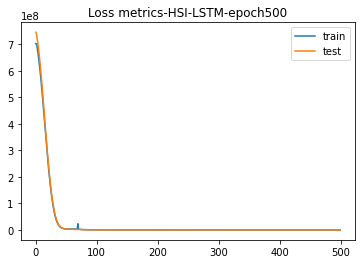

In [9]:
plt.plot(history_tech.history['loss'], label='train')
plt.plot(history_tech.history['val_loss'], label='test')
plt.title('Loss metrics-HSI-LSTM-epoch500')
plt.legend()

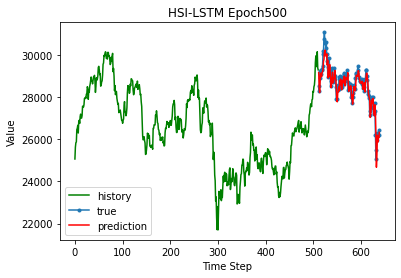

In [10]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
# plt.plot(np.arange(0, len(y_train)), sc_y.inverse_transform(y_train), 'g', label="history")
# plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), sc_y.inverse_transform(y_test), marker='.', label="true")
# plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), sc_y.inverse_transform(y_pred), 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.title('HSI-LSTM Epoch500')
plt.legend()
plt.show()

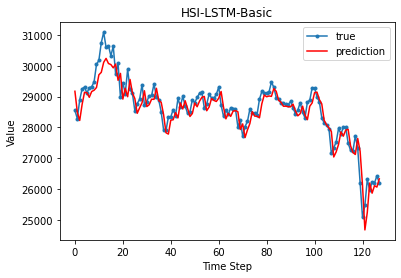

In [11]:
# y_test = sc.inverse_transform(y_test)
# y_pred = sc.inverse_transform(y_pred)
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.title('HSI-LSTM-Basic')
plt.legend()
plt.show();

In [12]:
r2_score(y_test,y_pred)

0.8426345175029061

In [13]:
mean_absolute_percentage_error(y_test,y_pred)

0.01098791509664815

In [14]:
mean_squared_error(y_test,y_pred,squared=False)

398.62376107241363

In [15]:
x_val=data_val.drop('Prediction',1).values
# x_val=x_val.reshape(x_val.shape[0],1,x_val.shape[1])
y_val=data_val['Prediction']
# x_val=x_val.reshape(x_val.shape[0],1,x_val.shape[1])
x_val=sc.transform(x_val).reshape(x_val.shape[0],1,x_val.shape[1])
y_val_pred=model_tech.predict(x_val)
# y_val_pred=sc_y.inverse_transform(y_val_pred)

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_94886/264374676.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_val=data_val.drop('Prediction',1).values
/opt/homebrew/Caskroom/miniforge/base/envs/fyp_new/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
2022-04-12 23:12:57.255123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 23:12:57.333573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 23:12:57.364040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


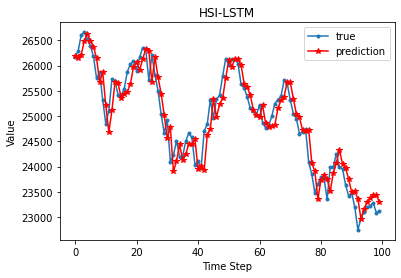

In [16]:
plt.plot(y_val.values, marker='.', label="true")
plt.plot(y_val_pred, 'r', marker='*',label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.title('HSI-LSTM')
plt.legend()
plt.show()

In [17]:
r2_score(y_val,y_val_pred)

0.9052931171112552

In [18]:
mean_absolute_percentage_error(y_val,y_val_pred)

0.010128790917062279

In [19]:
mean_squared_error(y_val.values,y_val_pred,squared=False)

308.1566446174406